In [ ]:
!pip install --no-dependencies -q horama timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.0 MB/s eta 0:00:00


In [1]:
import matplotlib.pyplot as plt

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

import torch
import timm
from horama import maco, fourier, plot_maco
from horama.plots import show
import numpy as np

%config InlineBackend.figure_format = 'retina'



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def to_numpy(tensor):
    # Ensure tensor is on CPU and convert to NumPy
    return tensor.detach().cpu().numpy()

def check_format(arr):
    # ensure numpy array and move channels to the last dimension
    # if they are in the first dimension
    if isinstance(arr, torch.Tensor):
        arr = to_numpy(arr)
    if arr.shape[0] == 3:
        return np.moveaxis(arr, 0, -1)
    return arr

def normalize(image):
    # normalize image to 0-1 range
    image = np.array(image, dtype=np.float32)
    image -= image.min()
    image /= image.max()
    return image

def clip_percentile(img, p=0.1):
    # clip pixel values to specified percentile range
    return np.clip(img, np.percentile(img, p), np.percentile(img, 100-p))

def show(img, **kwargs):
    # display image with normalization and channels in the last dimension
    img = check_format(img)
    img = normalize(img)

    plt.imshow(img, **kwargs)
    plt.axis('off')

def plot_maco(image, alpha, percentile_image=1.0, percentile_alpha=80):
    # visualize image with alpha mask overlay after normalization and clipping
    image, alpha = check_format(image), check_format(alpha)
    image = clip_percentile(image, percentile_image)
    image = normalize(image)

    # mean of alpha across channels, clipping, and normalization
    alpha = np.mean(alpha, -1, keepdims=True)
    alpha = np.clip(alpha, None, np.percentile(alpha, percentile_alpha))
    alpha = alpha / alpha.max()

    # overlay alpha mask on the image
    plt.imshow(np.concatenate([image, alpha], -1))
    plt.axis('off')

In [28]:
model_name = 'resnet18'

model = timm.create_model(model_name, pretrained=True).cuda().eval()

obj = lambda images: -torch.mean(torch.square(model.forward_features(images)))

image1, alpha1 = fourier(obj,
     decay_power=1.9,
     total_steps=2000,
     learning_rate=1.0,
     image_size=4096,
     model_input_size=224,
     noise=0.05,
     values_range=(-2.5, 2.5),
     crops_per_iteration=6,
     box_size=(0.05, 0.5),
     device='cuda')

np.save(f'baseline_{model_name}.npy', np.array(image1.detach().cpu().numpy()).astype(np.float32))

100%|██████████| 2000/2000 [06:35<00:00,  5.06it/s]


In [ ]:
models = [
    "tf_efficientnet_b0.in1k",
    "res2next50.in1k",
    "vgg19_bn.tv_in1k",
    "vgg16_bn.tv_in1k",
    "vit_small_patch16_224.augreg_in1k",
    "resnet33ts.ra2_in1k",
    "resnetrs50.tf_in1k",
    "res2net50d.in1k",
    "resnet50.b2k_in1k",
    "deit_small_distilled_patch16_224.fb_in1k",
    "convmixer_1536_20.in1k",
    "vit_small_patch16_224.augreg_in21k_ft_in1k",
    "poolformer_s36.sail_in1k",
    "resnext101_32x16d.fb_ssl_yfcc100m_ft_in1k",
    "deit3_small_patch16_224.fb_in22k_ft_in1k"
]

for model_name in models:

  model = timm.create_model(model_name, pretrained=True).cuda().eval()

  def obj(images):
    A = model.forward_features(images)
    return torch.mean(1.0 / (torch.square(A) + 1e-1))

  image1, alpha1 = fourier(obj,
      decay_power=1.8,
      total_steps=1000,
      learning_rate=1.0,
      image_size=4096,
      model_input_size=224,
      noise=0.03,
      values_range=(-2.5, 2.5),
      crops_per_iteration=6,
      box_size=(0.08, 0.4),
      device='cuda')

  set_size(10, 10)
  print(model_name)

  show(image1)
  f1 = f"baseline_{model_name}.png"
  plt.savefig(f1, dpi=400, transparent=True)
  plt.clf(); plt.close()

  plot_maco(image1, alpha1)
  f1 = f"baseline_{model_name}_maco.png"
  plt.savefig(f1, dpi=400, transparent=True)
  plt.clf(); plt.close()

  #np.save(f'baseline_{model_name}.npy', np.array(image1.detach().cpu().numpy()).astype(np.float32))

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


tf_efficientnet_b0.in1k


100%|██████████| 1000/1000 [03:07<00:00,  5.32it/s]


res2next50.in1k


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


vgg19_bn.tv_in1k


  2%|▏         | 23/1000 [00:04<03:15,  4.99it/s]

In [19]:
model_name = 'resnet18'

model = timm.create_model(model_name, pretrained=True).cuda().eval()

obj = lambda images: -torch.mean(torch.square(model.forward_features(images)))

image1, alpha1 = fourier(obj,
     decay_power=1.9,
     total_steps=2000,
     learning_rate=1.0,
     image_size=4096,
     model_input_size=224,
     noise=0.05,
     values_range=(-2.5, 2.5),
     crops_per_iteration=6,
     box_size=(0.10, 0.7),
     device='cuda')

np.save(f'baseline_{model_name}.npy', np.array(image1).astype(np.float32))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

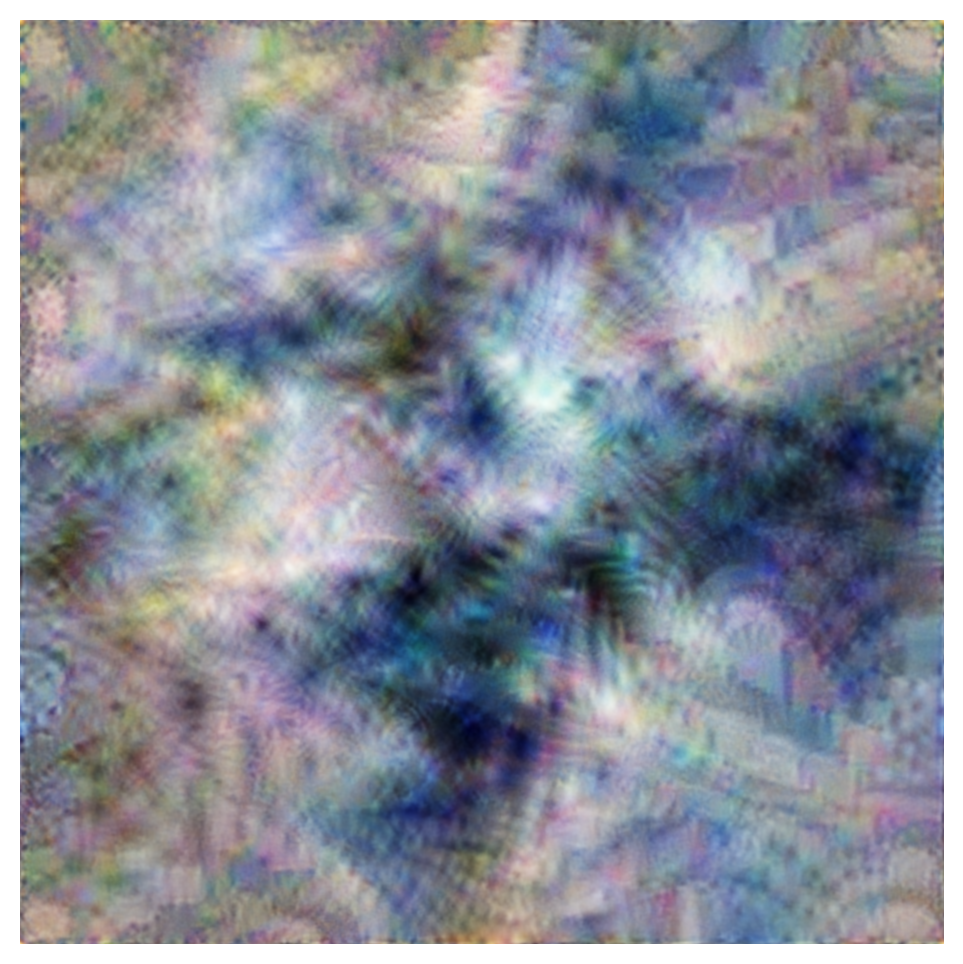

In [27]:
set_size(6, 6)
show(image1)

In [ ]:
objective = lambda images: torch.mean(model(images)[:, 1])

image1, alpha1 = maco(objective)
plot_maco(image1, alpha1)

image2, alpha2 = fourier(objective)
plot_maco(image2, alpha2)